## Email Subject Line Generator (DistilGPT-2 / Prompt Engineering)

**Author:** Visshva R  
**Environment:** Jupyter (Python 3.x)

### What this notebook does
- Loads a tiny demo set (or an Enron subset) of short descriptions
- Uses DistilGPT-2 to draft short subject lines
- Lets me tweak the prompt and decoding knobs (temperature/top-k/top-p)
- Saves a CSV/JSON and shows a quick length plot
- Picks the best lines with a simple “best-of-N” filter

## 1) Setup & Installs

In [ ]:
# === Install dependencies (run once) ===
# Tip: Run this ONLY when you create a new environment or see ModuleNotFoundError.

import sys

# ---- Choose ONE torch install ----
# A) CPU-only (works everywhere; fine for this project)
!{sys.executable} -m pip install -q torch --index-url https://download.pytorch.org/whl/cpu

# B) Or GPU (RTX 4060; faster). Comment A) and uncomment this:
# !{sys.executable} -m pip install -q torch --index-url https://download.pytorch.org/whl/cu121

# Core libs
!{sys.executable} -m pip install -q "transformers==4.44.2" pandas matplotlib pyarrow

In [1]:
# --- Setup & Imports (fast re-runnable) ---

# Working directory
import os
from pathlib import Path
PROJECT_DIR = Path(r"C:\Users\vissh\Documents\My Projects\Email Subject Generator")
PROJECT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(PROJECT_DIR)

OUTPUT_DIR = PROJECT_DIR / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Working dir:", Path.cwd())
print("Outputs   :", OUTPUT_DIR.resolve())

# Usual imports
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Silence a harmless warning (optional)
import warnings
warnings.filterwarnings("ignore", message="`clean_up_tokenization_spaces`")

# Force Transformers to use PyTorch only
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

# Model init (PyTorch)
from transformers import pipeline, set_seed
import torch

set_seed(42)
MODEL_NAME = "distilgpt2"   # instead of "gpt2"
device = 0 if torch.cuda.is_available() else -1

generator = pipeline(
    "text-generation",
    model=MODEL_NAME,
    framework="pt",
    device=device,
)
print("Loaded model:", MODEL_NAME, "| device:", "cuda:0" if device == 0 else "cpu")

Working dir: C:\Users\vissh\Documents\My Projects\Email Subject Generator
Outputs   : C:\Users\vissh\Documents\My Projects\Email Subject Generator\outputs
Loaded model: distilgpt2 | device: cpu



## 2) Load Dataset

You have two options:

1. **Quick Demo (recommended to verify the pipeline):** uses a tiny, hardcoded dataset.  
2. **Enron Dataset:** download from Kaggle and point to a CSV with an `email_body` or `text` column.  
   - Kaggle link: https://www.kaggle.com/datasets/wcukierski/enron-email-dataset  
   - After download, set `ENRON_CSV_PATH` below.


In [2]:
# --- Option A: Quick Demo Data (safe defaults) ---
demo_data = pd.DataFrame({
    "description": [
        "Email about upcoming event",
        "Reminder for payment due tomorrow",
        "Discount offer on electronics",
        "Meeting rescheduled to next week",
        "Welcome email for new subscribers",
        "Follow-up on interview schedule",
        "Webinar invitation for AI trends",
    ]
})

# --- Option B: Enron CSV (configure path and simple parsing) ---
# Put your downloaded CSV path here (leave None to skip)
ENRON_CSV_PATH = None  # e.g., r"data/enron_messages.csv"

def load_enron_subset(csv_path: str, n_rows: int = 500) -> pd.DataFrame:
    """
    Loads a subset of Enron CSV and extracts a brief 'description'
    by taking the first line/sentence from the email body.
    Adjust the column name as per your CSV.
    """
    df_raw = pd.read_csv(csv_path)
    # Try common column names. Adjust if your file differs.
    candidate_cols = ["body", "text", "message", "content"]
    body_col = None
    for c in candidate_cols:
        if c in df_raw.columns:
            body_col = c
            break
    if body_col is None:
        raise ValueError(f"Could not find an email body column in {df_raw.columns}. "
                         "Please rename one to 'body' or set below.")

    # Simple cleaning + description extraction
    def to_description(s: str) -> str:
        if not isinstance(s, str):
            return ""
        s = s.strip().replace("\r", " ").replace("\n", " ")
        # Take first ~12 words as a brief description
        words = s.split()
        return " ".join(words[:12]) if words else ""

    df = pd.DataFrame({"description": df_raw[body_col].astype(str).map(to_description)})
    df = df[df["description"].str.len() > 0].head(n_rows).reset_index(drop=True)
    return df

if ENRON_CSV_PATH and Path(ENRON_CSV_PATH).exists():
    df = load_enron_subset(ENRON_CSV_PATH, n_rows=600)
    source = "enron_subset"
else:
    df = demo_data.copy()
    source = "demo"

print(f"Loaded {len(df)} rows from: {source}")
df.head()

Loaded 7 rows from: demo


,description
0,Email about upcoming event
1,Reminder for payment due tomorrow
2,Discount offer on electronics
3,Meeting rescheduled to next week
4,Welcome email for new subscribers


## 3) Model Ready Check (DistilGPT-2 / PyTorch)

The model is already loaded above; this cell just confirms it’s ready.

In [ ]:
# Sanity check
assert 'generator' in globals(), "Run Cell 1 first — it creates `generator`."
print("OK ✅  Model ready:", MODEL_NAME, "| device:",
      "cuda:0" if ('device' in globals() and device == 0) else "cpu")

## 4) Prompt Engineering Utilities

Change the prompt template and decoding parameters to see how outputs differ.

In [3]:
import re
import unicodedata  

SAFE_MAX_WORDS = 5

# A compact prompt that keeps subjects short and avoids links/markdown.
BASE_TEMPLATE = (
    "You are a professional email copywriter.\n"
    "Write ONE short email subject line.\n"
    "Rules: <= 5 words, Title Case, no emojis/quotes,\n"
    "no links, no brackets/parentheses, no markdown, no code,\n"
    "no first-person pronouns (I, I'm, my, we, us, our),\n"
    "avoid 'Re:' and 'Fwd:'.\n\n"
    "Description: {desc}\n"
    "Subject:"
)

BAD_ENDINGS = {"a","an","the","of","to","for","and","in","with","on","at","by"}
BAD_ENDINGS |= {"or","is","this","be","are"}
FORBID_PRONOUNS = {"i","i'm","im","me","my","mine","we","us","our","ours"}
NEG_TOKENS = {"not","no","never","sorry","can't","won't","don't","cannot"}  
ACRONYMS = {"ai","ml","nlp"}
INSTRUCTION_TOKENS = {"title","write","subject","line","description","topic","brief","one"}

STOPWORDS = {
    "a","an","the","of","to","for","and","in","with","on","at","by","from",
    "is","are","be","this","that","your","our","my","we","you","about","email"
}

def _titleize(tokens):
    out = []
    for i, t in enumerate(tokens):
        low = t.lower()
        if low in ACRONYMS:
            out.append(low.upper())
        elif i == 0 or len(t) >= 3:
            out.append(t.capitalize())
        else:
            out.append(low)
    return " ".join(out)

def clean_subject(s: str, fallback: str = "") -> str:
    # keep first line and strip junk
    s = s.split("\n")[0].replace("Subject:", "")
    s = re.sub(r'(?:re:|fwd:)\s*', '', s, flags=re.I)
    s = re.sub(r'http\S+|www\.\S+|mailto:\S+', '', s)
    s = re.sub(r'[\[\]()<>`"*#~|\\=/?:]', ' ', s)
    s = s.strip(' "\'')
    s = unicodedata.normalize("NFKD", s)         
    s = re.sub(r'[^\x00-\x7F]+', ' ', s)          
    s = re.sub(r'[^A-Za-z0-9\s]', ' ', s)          
    s = re.sub(r'\s+', ' ', s).strip()

    toks = []
    for t in s.split():
        low = t.lower()
        # drop pure numbers OR any token containing digits (e.g., "8pm")
        if t.isdigit() or any(ch.isdigit() for ch in t):
            continue
        # keep only alphabetic tokens (we’ll re-titlecase "AI" later)
        if not t.isalpha():
            continue
        # drop first-person pronouns and banned words (case-insensitive)
        if low in FORBID_PRONOUNS or low in BAD_STRINGS_LOWER:
            continue
        # drop single-letter tokens
        if len(t) == 1:
            continue
        toks.append(t)


    # de-dup + cap
    dedup = []
    for t in toks:
        if not dedup or t.lower() != dedup[-1].lower():
            dedup.append(t)
    toks = dedup[:SAFE_MAX_WORDS]

    # fallback if too short or ends with stop-word
    if len(toks) < 2 or (toks and toks[-1].lower() in BAD_ENDINGS):
        fb = re.sub(r'[^A-Za-z0-9\s]', ' ', fallback)
        fb = re.sub(r'\s+', ' ', fb).strip().split()
        fb = [w for w in fb if w.lower() not in STOPWORDS][:SAFE_MAX_WORDS]
        if len(fb) >= 2:
            toks = fb

    subj = _titleize(toks).rstrip(' .,!?:;-/\\')
    return subj

BAD_STRINGS = {
    "http","www","href","mailto","re","re:","fwd","fwd:",
    "<",">","[","]","(",")","`","*","#","|","\\","_","=",
    "hello","please","thanks","thank","emoji","yes",
    "write","subject","line","description","topic","brief","one",
    "hey","title","guys","ve"  
}                     
BAD_STRINGS_LOWER = {b.lower() for b in BAD_STRINGS}
bad_words_ids = [generator.tokenizer.encode(t, add_special_tokens=False) for t in BAD_STRINGS]

def _kw(s):  # tiny helper
    return {w.lower() for w in re.findall(r'\b\w+\b', s) if w.lower() not in STOPWORDS}

def generate_subject(
    description: str,
    template: str = BASE_TEMPLATE,
    max_new_tokens: int = 16,
    temperature: float = 0.7,
    top_k: int = 40,
    top_p: float = 0.9,
    num_return_sequences: int = 1,
    max_tries: int = 3,
) -> str:
    prompt = template.format(desc=description.strip())
    desc_kw = _kw(description)  # NEW
    last = ""
    for _ in range(max_tries):
        out = generator(
            prompt,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            no_repeat_ngram_size=3,
            repetition_penalty=1.2,
            num_return_sequences=1,
            pad_token_id=50256,
            bad_words_ids=bad_words_ids,
            eos_token_id=generator.tokenizer.eos_token_id,
        )[0]["generated_text"]
        gen = out.replace(prompt, "")
        cleaned = clean_subject(gen, fallback=description)
        last = cleaned

        # Reject instruction echoes and negatives not present in description
        if any(t in cleaned.lower().split() for t in INSTRUCTION_TOKENS):
            continue
        if any(n in cleaned.lower().split() for n in NEG_TOKENS) and not (_kw(description) & NEG_TOKENS):
            continue

        # Accept good generations
        if len(cleaned.split()) >= 2 and cleaned.split()[-1].lower() not in BAD_ENDINGS:
            return cleaned

# Generate several candidates and keep the ones that best match the description.
def best_of_n(description: str, n: int = 10, k: int = 2, min_overlap: int = 1):
    cands, seen = [], set()
    for _ in range(n):
        s = generate_subject(description)
        key = s.lower()
        if key not in seen:
            seen.add(key)
            cands.append(s)

    dset = _kw(description)

    def score(subj: str) -> tuple[int, float]:
        sset = _kw(subj)
        overlap = len(dset & sset)
        return (overlap, 0.05 * len(sset))  # prioritize overlap, tiny length bonus

    cands.sort(key=lambda s: score(s), reverse=True)

    # first pass: keep those meeting the overlap gate
    selected = []
    for s in cands:
        if score(s)[0] >= min_overlap:
            selected.append(s)
        if len(selected) == k:
            break

    # second pass: if fewer than k, fill with next best by score
    if len(selected) < k:
        for s in cands:
            if s not in selected:
                selected.append(s)
            if len(selected) == k:
                break

    # final fallback if nothing
    if not selected:
        selected = [clean_subject("", fallback=description)]
    return selected

## 5) Quick Smoke Test

In [4]:
test_desc = "Email about upcoming event with keynote speaker"
print("Generated:", generate_subject(test_desc))

Generated: Upcoming Event Keynote Speaker


## 6) Batch Generation Over the Dataset (best-of-n with overlap scoring)

Generates up to NUM_VARIANTS clean, relevant subjects per description.

In [5]:
NUM_VARIANTS = 2
CANDIDATES_PER_DESC = 15

all_subjects = []
for _, row in df.iterrows():
    desc = row["description"]
    for v in best_of_n(desc, n=CANDIDATES_PER_DESC, k=NUM_VARIANTS, min_overlap=1): 
        all_subjects.append({"description": desc, "generated_subject": v})
gen_df = pd.DataFrame(all_subjects)
display(gen_df.head(10))

,description,generated_subject
0,Email about upcoming event,Upcoming Event
1,Email about upcoming event,The World of Warcraft Event
2,Reminder for payment due tomorrow,Reminder Payment Due Tomorrow
3,Reminder for payment due tomorrow,Payment Due to Your Payday
4,Discount offer on electronics,Discount Offer Electronics
5,Discount offer on electronics,Discount Offers to People Who
6,Meeting rescheduled to next week,Meeting Rescheduled Next Week
7,Meeting rescheduled to next week,Got More Than Two Hours
8,Welcome email for new subscribers,Welcome New Subscribers
9,Welcome email for new subscribers,Read The Following Guidelines When


## 7) Simple Analysis & Visualizations

We do quick checks: length distribution, uniqueness, and a few samples.  

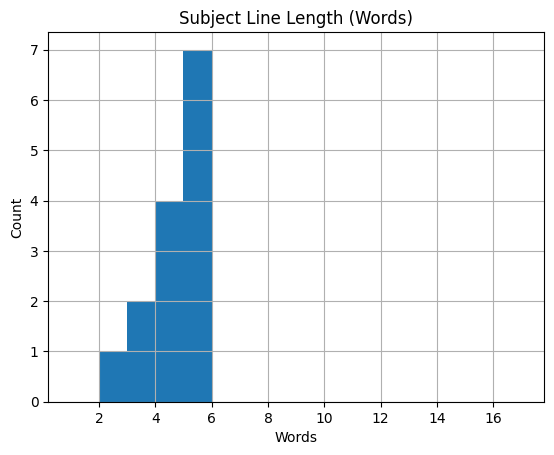

Uniqueness ratio: 100.00%

Random sample:


,description,generated_subject,len_words
9,Welcome email for new subscribers,Read The Following Guidelines When,5
11,Follow-up on interview schedule,All Comments Will be Posted,5
0,Email about upcoming event,Upcoming Event,2
12,Webinar invitation for AI trends,Webinar Invitation AI Trends,4
5,Discount offer on electronics,Discount Offers to People Who,5
8,Welcome email for new subscribers,Welcome New Subscribers,3
2,Reminder for payment due tomorrow,Reminder Payment Due Tomorrow,4
1,Email about upcoming event,The World of Warcraft Event,5
13,Webinar invitation for AI trends,AI Trends at Google Conference,5
4,Discount offer on electronics,Discount Offer Electronics,3


In [6]:
# Length (words) distribution
gen_df["len_words"] = gen_df["generated_subject"].str.split().map(len)

plt.figure()
gen_df["len_words"].hist(bins=range(1,18))
plt.title("Subject Line Length (Words)")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()

# Uniqueness ratio
uniq_ratio = gen_df["generated_subject"].nunique() / len(gen_df)
print(f"Uniqueness ratio: {uniq_ratio:.2%}")

# Show a random sample
print("\nRandom sample:")
display(gen_df.sample(min(10, len(gen_df)), random_state=42))

## 8) Save Outputs (CSV + JSON)

In [7]:
csv_path = OUTPUT_DIR / f"generated_subjects_{source}.csv"
json_path = OUTPUT_DIR / f"generated_subjects_{source}.json"

gen_df.to_csv(csv_path, index=False)
gen_df.to_json(json_path, orient="records", force_ascii=False, indent=2)

print("Saved:")
print(" -", csv_path.resolve())
print(" -", json_path.resolve())

Saved:
 - C:\Users\vissh\Documents\My Projects\Email Subject Generator\outputs\generated_subjects_demo.csv
 - C:\Users\vissh\Documents\My Projects\Email Subject Generator\outputs\generated_subjects_demo.json


## 9) Prompt Experiments

These quick variants show how small prompt changes shift tone and word choice.

In [ ]:
EXPERIMENT_TEMPLATES = {
    "baseline": (
        "You are a professional email copywriter.\n"
        "Write ONE short email subject line.\n"
        "Constraints: <= 5 words, Title Case, no links/markdown.\n\n"
        "Description: {desc}\n"
        "Subject:"
    ),
    "urgent": (
        "Write ONE urgent email subject. <= 5 words, Title Case.\n"
        "No links/markdown.\n\n"
        "Topic: {desc}\n"
        "Subject:"
    ),
    "benefit_driven": (
        "Create a benefit-driven subject in <= 5 words, Title Case.\n"
        "No links/markdown.\n\n"
        "Brief: {desc}\n"
        "Subject:"
    ),
}

sample_desc = "Reminder for payment due tomorrow"
for name, tmpl in EXPERIMENT_TEMPLATES.items():
    out = generate_subject(sample_desc, template=tmpl)  # no [0]
    print(f"[{name}] -> {out}")

## 10) Report Notes

**Prompt Engineering Strategy**
- Start with a clear role: “You are a professional email copywriter…”
- Constraints: ≤ 5 words, Title Case, no links/markdown/first-person; avoid “Re:”/“Fwd:”.
- Decoding: temperature=0.6, top_k=40, top_p=0.9, no_repeat_ngram_size=3, repetition_penalty=1.2.
- Filters: normalize non-ASCII, ban href/http/Re:/Fwd:/hello/please/thanks, reject instruction-echo and negative phrasing unless present in the description.
- Selection: best-of-N sampling with keyword-overlap scoring (min_overlap=1 for 2 variants, 2 for stricter).
- Model: DistilGPT-2 (lighter GPT-2) via transformers (PyTorch).

**Observations**
- Subjects are short and punchy (mostly 3–5 words) after filtering.
- Overlap scoring improved topical relevance vs raw sampling; fewer random/echoed lines.
- Style variants (baseline/urgent/benefit-driven) shift tone; “urgent” adds action verbs.
- A small fraction fallback to a cleaned description when generations fail quality checks.

**Limitations**
- No ground-truth labels → cannot report accuracy; this is a generation/UX task.
- Vague descriptions can still yield generic outputs.
- Overlap gate may filter out creative but off-topic ideas.
- Simple Title Case heuristic; may not match every brand style.

**Improvements**
- Fine-tune DistilGPT-2 on a small curated subject dataset.
- Add must-include keyword constraints (e.g., “Webinar”, dates) and a light re-ranker (embedding similarity).
- Expand style prompts (urgent/benefit/curiosity) and A/B test click-through.
- Add grammar/title-case checks and domain rules (avoid spammy terms).

## 11) Export a README.md (for GitHub)

In [ ]:
readme = """# Email Subject Line Generator 

This repo contains a Jupyter Notebook that generates catchy **email subject lines** from brief descriptions using a pretrained **DistilGPT-2** model (Hugging Face `transformers`).

## How to Run
1. Create/activate a Python 3.10+ environment
2. Install dependencies:
   ```bash
   pip install transformers torch pandas matplotlib
   ```
3. Open `Email Subject Generator.ipynb` in Jupyter/VSCode/Colab
4. Run cells top to bottom
5. (Optional) Download Enron dataset from Kaggle and set `ENRON_CSV_PATH` in the notebook

## Files
- `Email Subject Generator.ipynb` – main notebook
- `outputs/` – generated CSV/JSON results

## Notes
- Start with the demo dataset to verify everything works.
- Then switch to Enron for more realistic inputs.
- Tune prompt templates & decoding parameters to improve results.

## Author
Visshva R
"""
from pathlib import Path
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / "README.md").write_text(readme, encoding="utf-8")
print("Wrote README to:", (OUTPUT_DIR / "README.md").resolve())